### Content Analysis Political - Foreign Policy Posts
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("political/Topics_FB_Political_Posts_per_partyforeign_policy.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(406, 35)

In [5]:

posts.shape

(406, 35)

In [6]:
posts['URL']

0      https://www.facebook.com/latinosvstrump/posts/...
1      https://www.facebook.com/LatinosforJoe/posts/5...
2      https://www.facebook.com/LatinosforJoe/posts/6...
3      https://www.facebook.com/LatinosforJoe/posts/6...
4      https://www.facebook.com/LatinosforJoe/posts/6...
                             ...                        
401    https://www.facebook.com/groups/16256741844186...
402    https://www.facebook.com/groups/16256741844186...
403    https://www.facebook.com/groups/16256741844186...
404    https://www.facebook.com/groups/16256741844186...
405    https://www.facebook.com/groups/16256741844186...
Name: URL, Length: 406, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [7]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [8]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [9]:
posts["Created"].head(5)

0    2020-10-24 07:01:48 EDT
1    2020-08-31 21:10:13 EDT
2    2020-11-03 09:01:50 EST
3    2020-09-27 01:48:13 EDT
4    2020-10-21 18:16:43 EDT
Name: Created, dtype: object

In [10]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0     2020-10-24 07:01:48-04:00
1     2020-08-31 21:10:13-04:00
2     2020-11-03 09:01:50-05:00
3     2020-09-27 01:48:13-04:00
4     2020-10-21 18:16:43-04:00
                 ...           
401   2020-09-10 16:54:52-04:00
402   2020-09-06 20:21:58-04:00
403   2020-09-06 13:04:54-04:00
404   2020-09-02 03:25:24-04:00
405   2020-08-20 17:51:03-04:00
Name: converted_date, Length: 406, dtype: datetime64[ns, tzlocal()]

In [11]:
posts['converted_date']=posts['converted_date'].dt.date

In [12]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,1
1,2020-08-19,4
2,2020-08-20,6
3,2020-08-21,1
4,2020-08-22,2
5,2020-08-23,3
6,2020-08-24,9
7,2020-08-25,9
8,2020-08-26,3
9,2020-08-27,5


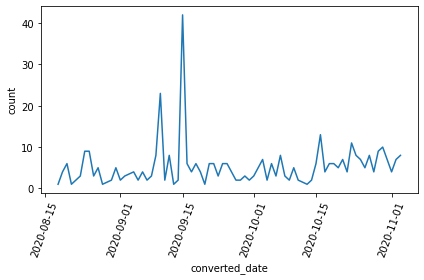

In [13]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [14]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date
0,193,Latinos Contra Trump,latinosvstrump,1161597243956409,229460.0,2020-10-24 07:01:48 EDT,Link,123,77,50,...,"Esa es la Cara de Trump Cuando su Gran Aliado,...",La mirada en el rostro de Trump NO TIENE PRECI...,NaN,NaN,334,-1.36,¿Será que los sabuesos israelíes ya le dijeron...,¿Será que los sabuesos israelíes ya le dijeron...,Democrat,2020-10-24


In [15]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [16]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [17]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [18]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
DONALD TRUMP PARA HISPANOS,50
Latinos For Trump -California Group,40
Latinos For Trump.,30
Mexicans for Donald Trump,24
CARA - Cuban American Republican Alliance,23
Republican National Hispanic Assembly - Official Group,19
Mexican Chicas For Trump,14
Colombianos Y Latinoamericanos que apoyamos a Donald Trump,14
Republican National Hispanic Assembly of Florida,13


## Tokenize words and Clean-up text

In [19]:
content = posts.copy()
content.drop_duplicates(subset= ['MessageDescr'], inplace=True)
content['MessageDescr']

0      ¿Será que los sabuesos israelíes ya le dijeron...
1      Another great endorsement! https://abcnews.go....
2      These are his values and American values. http...
3      Exactly. https://www.theguardian.com/us-news/2...
4      We only be back if we win the election. Vote a...
5      He doesn't want to jeopardize a future relatio...
6      We need more staff to stand up to our foreign ...
7      This is why the plan won't work. https://www.p...
8      Susan Rice: "Never in our history that I can t...
10      Fmr. Deputy National Security Adviser under P...
11     In his nomination letter, he wrote: 'As it is ...
12     Another historic achievement for Donald J. Tru...
13     The clown in the White House just brokered fou...
14     If anyone EVER doubted our President’s ability...
15     More foreign policy wins for the Trump adminis...
16     Breaking today: Foreign policy victory for pea...
17      AS A PROUD AMERICAN OF MIDDLE EAST ... A MUST...
18     🇺🇸 We want to express ou

In [20]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(318,)

In [21]:
# Convert to list
data = content.cleanMessage.tolist()

In [22]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['sera', 'que', 'los', 'sabuesos', 'israelies', 'ya', 'le', 'dijeron', 'su', 'primer', 'ministro', 'que', 'trump', 'va', 'perder', 'la', 'mirada', 'en', 'el', 'rostro', 'de', 'trump', 'no', 'tiene', 'precio', 'cuando', 'se', 'da', 'cuenta', 'de', 'que', 'todos', 'se', 'estan', 'volviendo', 'contra', 'el', 'esa', 'es', 'la', 'cara', 'de', 'trump', 'cuando', 'su', 'gran', 'aliado', 'el', 'premier', 'israeli', 'se', 'nego', 'ir', 'contra', 'biden'], ['another', 'great', 'endorsement']]


#### Creating Bigram and Trigram Models

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['sera', 'que', 'los', 'sabuesos', 'israelies', 'ya', 'le', 'dijeron', 'su', 'primer_ministro', 'que', 'trump', 'va', 'perder', 'la', 'mirada', 'en', 'el', 'rostro', 'de', 'trump', 'no', 'tiene', 'precio', 'cuando', 'se', 'da', 'cuenta', 'de', 'que', 'todos', 'se', 'estan', 'volviendo', 'contra', 'el', 'esa', 'es', 'la', 'cara', 'de', 'trump', 'cuando', 'su', 'gran', 'aliado', 'el', 'premier', 'israeli', 'se', 'nego', 'ir', 'contra', 'biden']


## Remove Stopwords, Make Bigrams and Lemmatize

In [25]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [28]:
data_lemmatized[0]

['sabueso',
 'israelies',
 'decir',
 'trump',
 'perder',
 'mirar',
 'rostro',
 'trump',
 'preciar',
 'contar',
 'volver',
 'caro',
 'trump',
 'gran',
 'aliar']

In [29]:
print(data_words_nostops[1:2])

[['another', 'great', 'endorsement']]


## Bag of Words

In [30]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [31]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [32]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [33]:
final_dict.most_common(1000)

[('donald / trump', 334),
 ('president / presidente', 186),
 ('gustar', 111),
 ('decir', 90),
 ('hacer', 86),
 ('paz', 68),
 ('ano', 67),
 ('estadounidense', 60),
 ('american / america', 59),
 ('peace', 58),
 ('unir', 52),
 ('personar', 51),
 ('tratar', 47),
 ('donar', 45),
 ('querer', 45),
 ('guerra', 43),
 ('country', 42),
 ('politica', 42),
 ('lograr', 40),
 ('acordar', 39),
 ('nuevo', 38),
 ('medio_oriente', 38),
 ('political', 37),
 ('embajada', 37),
 ('solo', 37),
 ('votar', 36),
 ('paises', 35),
 ('ahora', 34),
 ('poner', 34),
 ('creer', 33),
 ('ser', 33),
 ('producir', 32),
 ('cubano', 32),
 ('pasar', 31),
 ('dar', 31),
 ('mundo', 31),
 ('medio', 30),
 ('trabajar', 30),
 ('firmar', 30),
 ('gran', 29),
 ('ley', 28),
 ('apoyar', 28),
 ('americano', 28),
 ('crear', 28),
 ('virus', 27),
 ('partir', 27),
 ('ir', 27),
 ('hispano', 26),
 ('chino', 26),
 ('segundar', 25),
 ('poblar', 25),
 ('nunca', 24),
 ('casar', 24),
 ('millón', 24),
 ('isis', 23),
 ('general', 23),
 ('reducir', 23)

In [34]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [35]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [36]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [37]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,1.852536
presidente,2.704748
peace,2.936550
hacer,2.958529
decir,3.127605
america,3.209843
ano,3.209843
paz,3.268684
medio_oriente,3.299455
unir,3.331204


In [38]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [39]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
israelies,0.330670
rostro,0.330670
sabueso,0.330670
caro,0.308589
trump,0.302655
mirar,0.280771
aliar,0.270842
perder,0.270842
preciar,0.262447
contar,0.255175


In [40]:
pd.set_option('display.max_colwidth',None)
#word = df.index[8]
word = r"\b(evento)\b"
content["lowercase"] = content['MessageOnly'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')

word_messages

/home/claudia/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,unique_messages,counts
0,"la prensa ataca al presidente trump con mentiras sobre que no tomó en serio la emergencia del covid-19. los mismos ""reporteros"" que lo tildaron de xenófobo por prohibir los vuelos de china a ee. uu. en enero. repiten que no usaba mascarillas, lo cual es mentira, pues solo se la quitaba para hablar en conferencias y los podios los colocan a distancia. de todos modos, las mascarillas no impiden que una persona se infecte. las enfermeras y médicos se infectan, a pesar de que tienen precaución y usan mascarillas con mayor protección. ninguna prueba de covid-19 puede determinar dónde se infectó y quién infectó. por tanto, no hay forma de saber si fue en un evento de campaña o en la casa blanca. eso es irrelevante. la mayoría de la población se infectará de covid-19, como pasó con la influenza. un presidente de una nación no puede estar encerrado y aterrorizado como quería la prensa, solo para evitar infectarse. eso es absurdo. el presidente de brasil jair bolsonaro y el primer ministro de reino unido boris johnson se infectaron y recuperaron. this is a re-share of a post",1


### Repeated messages

In [41]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [42]:
##results.sort_values(by='Counts',ascending=False)

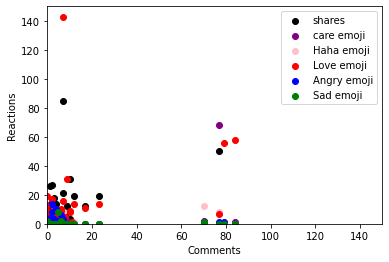

In [43]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [44]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1)]]


[[('aliar', 1),
  ('caro', 1),
  ('contar', 1),
  ('decir', 1),
  ('gran', 1),
  ('israelies', 1),
  ('mirar', 1),
  ('perder', 1),
  ('preciar', 1),
  ('rostro', 1),
  ('sabueso', 1),
  ('trump', 3),
  ('volver', 1)]]

## Buiding the Topic Model

In [45]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [46]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.068*"gustar" + 0.012*"tratar" + 0.011*"firmar" + 0.011*"homosexual" + '
  '0.009*"ahora" + 0.009*"ano" + 0.009*"guerra" + 0.009*"lograr" + '
  '0.008*"desempleo" + 0.008*"politica"'),
 (1,
  '0.012*"throughout" + 0.009*"racial" + 0.009*"justice" + '
  '0.005*"institutional" + 0.005*"dismissed" + 0.005*"bias" + '
  '0.003*"evangelical" + 0.000*"hebron" + 0.000*"side" + 0.000*"hamas"'),
 (2,
  '0.041*"salir" + 0.034*"mensaje" + 0.032*"nacional" + 0.030*"notar" + '
  '0.029*"rolar" + 0.026*"estrellar" + 0.023*"bienvenido" + 0.022*"moro" + '
  '0.022*"andres" + 0.022*"jessica"'),
 (3,
  '0.133*"peace" + 0.086*"also" + 0.043*"mexico" + 0.043*"states" + '
  '0.041*"especially" + 0.026*"two" + 0.012*"decades" + 0.010*"natural" + '
  '0.010*"total" + 0.008*"advisor"'),
 (4,
  '0.054*"control" + 0.053*"agree" + 0.030*"diplomatica" + 0.015*"local" + '
  '0.011*"additional" + 0.008*"sources" + 0.006*"close" + 0.006*"cancer" + '
  '0.005*"financial" + 0.004*"anadio"'),
 (5,
  '0.043*"pob

## Compute Model Perplexity and Coherence Score

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.668712184877684

Coherence Score:  0.47162475070259485


## Visualize the topics-keywords

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.356154 -0.017308       1        1  43.982750
5     -0.122968  0.136159       2        1  10.724475
0     -0.188088  0.091588       3        1  10.620879
8     -0.060147 -0.269208       4        1   7.379776
18    -0.087014 -0.040171       5        1   5.649285
15    -0.024614 -0.027418       6        1   4.359759
12     0.042131  0.030389       7        1   3.946172
7      0.050545  0.024983       8        1   2.534625
3      0.084951  0.031624       9        1   2.203950
13     0.080965  0.013665      10        1   2.086730
2      0.080603 -0.005638      11        1   1.719729
11     0.065939  0.011898      12        1   1.249611
14     0.065962 -0.021936      13        1   1.041641
4      0.062707  0.007312      14        1   0.734304
10     0.056980  0.005659      15        1   0.647624
16     0.058678  0.008572      16        1   0.560247
1      0.048811  0.005228      17        1   0.213975
17     0.047425  0.005001      18        1   0.140704
9      0.047179  0.004852      19        1   0.128547
19     0.046111  0.004750      20        1   0.075224, topic_info=                       Term        Freq       Total Category  logprob  loglift
11                    trump  550.000000  550.000000  Default  30.0000  30.0000
1177                 gustar   96.000000   96.000000  Default  29.0000  29.0000
18                  country  100.000000  100.000000  Default  28.0000  28.0000
28                    peace   47.000000   47.000000  Default  27.0000  27.0000
19                political   40.000000   40.000000  Default  26.0000  26.0000
416                embajada   38.000000   38.000000  Default  25.0000  25.0000
66                 national   43.000000   43.000000  Default  24.0000  24.0000
730                  poblar   62.000000   62.000000  Default  23.0000  23.0000
57                  central   31.000000   31.000000  Default  22.0000  22.0000
30                  america   51.000000   51.000000  Default  21.0000  21.0000
45                     also   25.000000   25.000000  Default  20.0000  20.0000
363              presidente  229.000000  229.000000  Default  19.0000  19.0000
534                   grupo   39.000000   39.000000  Default  18.0000  18.0000
315                   hacer  109.000000  109.000000  Default  17.0000  17.0000
439                 miembro   41.000000   41.000000  Default  16.0000  16.0000
3                     decir  100.000000  100.000000  Default  15.0000  15.0000
147                   donar   90.000000   90.000000  Default  14.0000  14.0000
29                president   21.000000   21.000000  Default  13.0000  13.0000
918                 sistema   24.000000   24.000000  Default  12.0000  12.0000
793              terrorista   29.000000   29.000000  Default  11.0000  11.0000
248                   legal   28.000000   28.000000  Default  10.0000  10.0000
276                    casi   32.000000   32.000000  Default   9.0000   9.0000
167                 general   30.000000   30.000000  Default   8.0000   8.0000
384                    vida   32.000000   32.000000  Default   7.0000   7.0000
1302                tambien   29.000000   29.000000  Default   6.0000   6.0000
265                     ano   69.000000   69.000000  Default   5.0000   5.0000
920                    solo   47.000000   47.000000  Default   4.0000   4.0000
663                  frente   23.000000   23.000000  Default   3.0000   3.0000
839                noticiar   20.000000   20.000000  Default   2.0000   2.0000
734                   poner   41.000000   41.000000  Default   1.0000   1.0000
1264               director   60.535625   61.225231   Topic1  -4.5727   0.8100
147                   donar   89.220108   90.245018   Topic1  -4.1848   0.8100
156                possible   51.643517   52.333126   Topic1  -4.7316   0.8081
94                     isis   50.181953   50.871563   Topic1  -4.7603   0.8077
4   

## Building LDA Mallet Model

In [49]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [51]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [52]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [53]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('donar', 0.10227272727272728),
   ('country', 0.07272727272727272),
   ('isis', 0.038636363636363635),
   ('dislike', 0.038636363636363635),
   ('medio', 0.031818181818181815),
   ('reform', 0.031818181818181815),
   ('radical', 0.02727272727272727),
   ('hatred', 0.025),
   ('agree', 0.022727272727272728),
   ('control', 0.022727272727272728)]),
 (4,
  [('equipar', 0.019536019536019536),
   ('ser', 0.017094017094017096),
   ('americano', 0.017094017094017096),
   ('medio', 0.015873015873015872),
   ('politica', 0.015873015873015872),
   ('alcohol', 0.015873015873015872),
   ('desarrollar', 0.013431013431013432),
   ('apoyar', 0.013431013431013432),
   ('liderar', 0.01221001221001221),
   ('marcar', 0.01098901098901099)]),
 (6,
  [('poblar', 0.03618421052631579),
   ('creer', 0.03125),
   ('personar', 0.023026315789473683),
   ('libertar', 0.02138157894736842),
   ('tiempo', 0.018092105263157895),
   ('chino', 0.018092105263157895),
   ('cargar', 0.01644736842105263),
   ('pri

## Finding the optimal number of topics for LDA

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [55]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

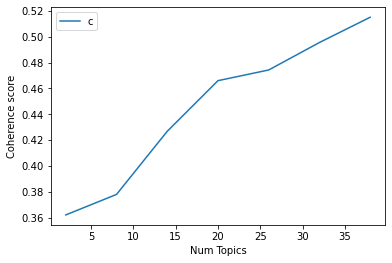

In [56]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3621
Num Topics = 8  has Coherence Value of 0.378
Num Topics = 14  has Coherence Value of 0.4268
Num Topics = 20  has Coherence Value of 0.466
Num Topics = 26  has Coherence Value of 0.4743
Num Topics = 32  has Coherence Value of 0.4955
Num Topics = 38  has Coherence Value of 0.5151


In [63]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(16,
  '0.048*"personar" + 0.046*"crear" + 0.037*"negro" + 0.037*"tratar" + '
  '0.034*"ley" + 0.028*"trabajar" + 0.028*"creer" + 0.023*"deber" + '
  '0.021*"racista" + 0.021*"nuevo"'),
 (26,
  '0.086*"assets_central" + 0.062*"national" + 0.035*"casi" + 0.031*"post" + '
  '0.027*"director" + 0.027*"central" + 0.023*"noticiar" + '
  '0.023*"arab_emirates" + 0.023*"notar" + 0.020*"comenzar"'),
 (5,
  '0.047*"apoyar" + 0.047*"poblar" + 0.040*"americano" + 0.032*"creer" + '
  '0.028*"poder" + 0.026*"familia" + 0.024*"entender" + 0.024*"ciudadano" + '
  '0.022*"unir" + 0.020*"politico"'),
 (25,
  '0.075*"solo" + 0.063*"ser" + 0.045*"querer" + 0.038*"vez" + '
  '0.033*"trabajar" + 0.031*"hoy" + 0.026*"llevar" + 0.023*"hablar" + '
  '0.023*"coser" + 0.019*"verdad"'),
 (6,
  '0.033*"equipar" + 0.028*"politica" + 0.022*"desarrollar" + 0.018*"marcar" + '
  '0.018*"calidad" + 0.016*"paz" + 0.014*"hoy" + 0.014*"frente" + '
  '0.014*"financiero" + 0.012*"democrata"'),
 (10,
  '0.040*"fiscal" + 0.0

## Finding the dominant topic in each sentence

In [64]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.0770,"estadounidense, gran, bueno, america, presidente, proteger, volver, empresa, pais, partir","¿Será que los sabuesos israelíes ya le dijeron a su Primer Ministro que Trump va a PERDER?... La mirada en el rostro de Trump NO TIENE PRECIO cuando se da cuenta de que todos se están volviendo contra él. Esa es la Cara de Trump Cuando su Gran Aliado, el Premier Israelí se Negó a ir Contra Biden"
1,1,0.0,0.0312,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",Another great endorsement!
2,2,13.0,0.0450,"peace, president, virus, producir, special, close, doesnt, arose, diseases, exposed",These are his values and American values.
3,3,0.0,0.0312,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",Exactly.
4,4,0.0,0.0312,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",We only be back if we win the election. Vote and tell others to vote for Biden.
5,5,13.0,0.0437,"peace, president, virus, producir, special, close, doesnt, arose, diseases, exposed",He doesnt want to jeopardize a future relationship.
6,6,0.0,0.0312,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",We need more staff to stand up to our foreign adversaries.
7,7,0.0,0.0312,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",This is why the plan wont work.
8,8,27.0,0.0616,"political, country, democrats, real, analysis, mexico, prior, losar, partner, asks","Susan Rice: ""Never in our history that I can think of have we had a president who really just doesnt care and who is willing to do extraordinary damage to this country that we all love and depend on for his own personal political benefit."" Susan Rice, former US Ambassador to the UN and National Security Adviser under President Obama, joins Andrea Mitchell to discuss President Trumps comments to Bob Woodward on white privilege, NSA Robert OBriens handling of the early warnings that the virus was a national security threat, and the P... Susan Rice: Trump does not give a damn about Americans health, safety, and national security"
9,9,4.0,0.0850,"paz, acordar, unir, decir, acuerdo, medio_oriente, anunciar, militar, historico, mediar",Fmr. Deputy National Security Adviser under Pres. Obama Ben Rhodes reacts to Mike Pompeos norm-busting RNC speech delivered from Jerusalem and what it means for American foreign policy and foreign relations. Ben Rhodes: Pompeos Hatch Act-violating RNC speech is dangerous


## Find the most representative document for each topic

In [65]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5492,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente","CARLOS ALBERTO MONTANER por Esteban Fernandez Fort Knox, Kentucky. Hoy hace exactamente 58 años que los sargentos nos sacaron a gritos pelados a una explanada, nos pusieron en ""atención"" y nosotros sin premeditación entonamos el himno nacional cubano. Ahí en el grupo estaba Carlos Alberto Montaner, quien a través de los años ha sido una gran decepción para mi. Carlos Alberto y yo entramos al ..."
1,1.0,0.6130,"presidente, mundial, usar, despues, candidato, amenazar, asi, momento, ninos, atacar",LA ALIANZA INFORMA un 1% DE LOS DESCLASIFICADOS. SE ESTAN SENSURANDO TODA LA INFORMACION QUE HABLE LAVERDAD DE LA FAMILIA biden. ATT = TWITTER 1. Situación del ex presidente y ex vicepresidente de USA (mejor no mencionarlo para que no nos baneen el grupo) ya que estan eliminando todos mensajes que lo mencionen. 2. El comunicado de un periodista del New York Time sobre los escandalos DEL HIJO ...
2,2.0,0.3232,"estadounidense, gran, bueno, america, presidente, proteger, volver, empresa, pais, partir","El presidente Trump da a conocer su agenda para el segundo mandato TRABAJOS · Cree 10 millones de nuevos trabajos en 10 meses · Crear 1 millón de nuevas pequeñas empresas · Reducir los impuestos para aumentar el salario neto y mantener los trabajos en Estados Unidos · Promulgar acuerdos de comercio justo que protejan los empleos estadounidenses · Créditos fiscales ""Made in America"" · Ampliar ..."
3,3.0,0.2673,"trump, presidente, ir, esfuerzo, noruego, nominar, premio_nobel, conflicto, cambiar, bombardear","EL PRESIDENTE QUE NOS IBA A LLEVAR A LA 3era GUERRA MUNDIAL... 😘 🚨🚨🚨 ÚLTIMA HORA: “Trump nominado al Premio Nobel de la Paz por miembro del Parlamento de Noruega: Apenas unas semanas después de ayudar a negociar la paz entre Israel y los Emiratos Árabes Unidos, el presidente Donald Trump ha sido nominado para el Premio Nobel de la Paz 2021. La nominación presentada por Christian Tybring-Gjedd..."
4,4.0,0.4053,"paz, acordar, unir, decir, acuerdo, medio_oriente, anunciar, militar, historico, mediar",#PazEnMedioOriente Trump declara un “día histórico para la paz” durante la firma de los acuerdos de Oriente Medio... ESTAMOS UNIDOS... Es tiempo de actuar!!! (La Gran Época).- El presidente Donald Trump declaró el martes que era un “día histórico para la paz” al firmarse dos acuerdos de paz históricos para Oriente Medio entre varios estados del Golfo e Israel. Trump dijo que este paso “cambia...
5,5.0,0.2280,"apoyar, poblar, americano, creer, poder, familia, entender, ciudadano, unir, politico","“Maldiciones de burros no llegan al cielo” Mientras el presidente de todos los americanos es hospitalizado debido al virus chino, y como medida de precaución, el mundo libre se estremece con la noticia, las bolsas de valores se desploman y el planeta se queda en vilo, y es que El líder del país más poderoso de mundo ejerce una influencia sin par en todas las naciones de la tierra. Líderes de ..."
6,6.0,0.5438,"equipar, politica, desarrollar, marcar, calidad, paz, hoy, frente, financiero, democrata","DONALD TRUMP GANARÁ LAS ELECCIONES DE NOVIEMBRE 2020 ABRUMADORAMENTE! 10 SECRETOS DE SU ÉXITO No hay duda de que el Congreso y la Casa de Representantes pasará a ser republicano, las razones son muy simples. En primer lugar el equipo de campaña Donald Trump ha sido inmensamente superior al de Biden y al equipo desorientado demócrata. Segundo, la imagen presentada es patriótica, espiritual y d..."
7,7.0,0.3618,"presidente, hacer, hispano, partir, republicano, tiempo, comunidad, tener, temer, querer","Por qué los latinos deberían votar por Donald Trump? Con el objetivo de incentivar la participación latina en las elecciones presidenciales del 3 de noviembre, El Tiempo ha contactado a representantes nacionales de las campañas de Donald Trump y Joe Biden, respectivamente, para exponer la ide

In [66]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [67]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"estadounidense, gran, bueno, america, presidente, proteger, volver, empresa, pais, partir",31.0,0.0975
1.0,0.0,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",3.0,0.0094
2.0,13.0,"peace, president, virus, producir, special, close, doesnt, arose, diseases, exposed",5.0,0.0157
3.0,0.0,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",7.0,0.0220
4.0,0.0,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",7.0,0.0220
5.0,13.0,"peace, president, virus, producir, special, close, doesnt, arose, diseases, exposed",2.0,0.0063
6.0,0.0,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",3.0,0.0094
7.0,0.0,"cubano, librar, considerar, terrorismo, hacer, carlos_alberto, norteamericano, contactar, traves, completamente",4.0,0.0126
8.0,27.0,"political, country, democrats, real, analysis, mexico, prior, losar, partner, asks",26.0,0.0818
9.0,4.0,"paz, acordar, unir, decir, acuerdo, medio_oriente, anunciar, militar, historico, mediar",2.0,0.0063
